In [1]:
# default_exp unsupervised
# default_cls_lvl 2

# Chapter 9. Unsupervised Learning
>

- Although most of the applications of machine learning algorithms today are based on supervised learning, The vast majority of the available data is **unlabeled**.
- We have the input $X$, but we don't have the labels $y$.
- Yann LeCun: "If intelligence was a cake, **Unsupervised Learning** would be the **cake**, **supervised learning** would be the **icing** on the cake, and **reinforcement learning** would be the **cherry** on the cake."
- In this chapter we will look at a few unsupervised learning tasks and algorithms:
    - Clustering: the goal is to group similar instances together into clusters.
        - Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning,..
    - Anomaly Detection: This is the task of estimating the probability density function of the random process that generated the dataset.
        - Instances located in very low-density regions are likley to be anomalies.

## Clustering

- Clustering: identifying groups containing similar objects.
- Consider the example of unsupervised clustering the Iris dataset
    - If we remove its labels, we can't use classification algorithms.
    - Unsupervised Learning Clustering make use of all available features to located clusters and assign all instances to one of them.
        - Using a Gaussian Mixture Model, only 5/150 are assigned to the wrong cluster.
- Clustering is used in:
    - Customer Segmentation
    - Data Analysis
        - It might be useful to cluster the instance and analyse each separately.
- Dimensionality Reduction
    - By replacing the features with each instance's affinity to each cluster.
- Anomaly Detection
    - Any instance that have low affinity to all clusters is likely to be an outlier.
- Semi-supervised Learning
    - If you have a few labels, you can perform clustering and propagate the available labels to other instances within the clusters.
- Search Engines
    - Image similarity search: clustering available images & when a new item is provided by the user, cluster it using the same algorithm and return the top N centered items.
- To segment an image
    - By clustering pixels according to their color, then replacing pixel colors with the mean of its cluster.
- There are different types of clustering algorithms and there isn't a universal definition of what a cluster is.
- In this section, we will look at two widely used unsupervised learning clustering algorithms, the first one is `KMeans` and the second is `DBSCAN`.

### K-Means

- Let's start with makes some data:

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt

In [3]:
X, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=5, cluster_std=[0.5, 0.5, 0.5, 1, 1])

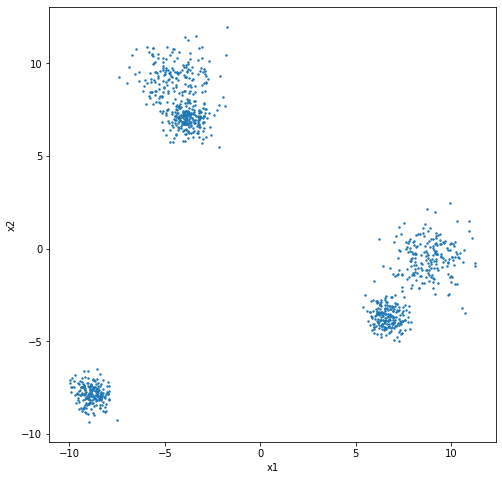

In [4]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

- Let's train a k-means clusterer on this dataset.

In [5]:
from sklearn.cluster import KMeans

In [6]:
k = 5

In [7]:
kmeans = KMeans(n_clusters=k)

In [8]:
y_pred = kmeans.fit_predict(X)

- Note that you have to specify the number of clusters to be found.


In [9]:
y_pred is kmeans.labels_

True

- We can also take a look at the five centroids the algorithm found:

In [10]:
kmeans.cluster_centers_

array([[-8.83963543, -7.83211351],
       [-3.79699191,  7.05763294],
       [ 8.84811103, -0.47723063],
       [ 6.65725535, -3.65718066],
       [-4.61472066,  9.44482072]])

- We can easily predict the cluster of new instances:

In [11]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

In [12]:
kmeans.predict(X_new)

array([1, 2, 1, 1], dtype=int32)

- By plotting the algorithm's decision boundaries, we get a Voronoi tesselation:

In [13]:
# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [14]:
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

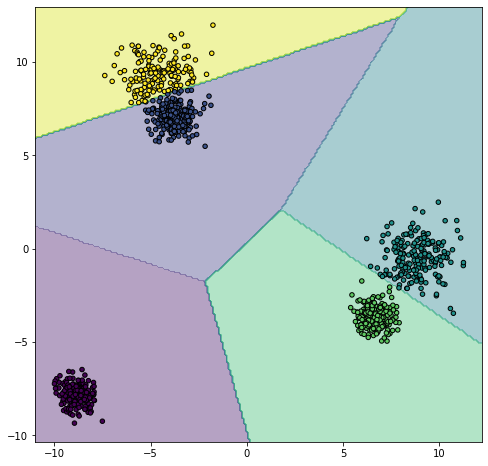

In [15]:
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=20, edgecolor='k')
plt.show()

- The vast majority of the instances were clearly assigned to their original cluster.
- All KMeans cares about is the distance between instances and the centroids.
- Instead of assigning each instance to a cluster (hard clustering) it's better to give a per-instance cluster score (soft clustering).
    - The score can be the distance between the instance and the centroids.
        - This can also be a good dimensionality reduction technique.
- In `sklearn`, the `transform` method measures the distance between each instance and the centroids.

In [16]:
kmeans.transform(X_new)

array([[13.22155855,  6.32430222,  9.18834808,  8.73628879,  8.75905259],
       [15.38984805,  8.47223406,  6.35114747,  6.73640926, 10.64938149],
       [12.30593454,  4.13516399, 12.34782847, 11.72947719,  6.64402264],
       [11.86818905,  4.62679308, 12.21644945, 11.45309803,  7.13006715]])

### `KMeans` Algorithm

- How does the algorithm work?
- Suppose you were given the centroids.
- You could easily label all the instances in the dataset by assigning each of them to the cluster with the closest centroid.
- Conversely, if you were given all the instance labels, you could easily locate all the centroids by computing the mean of the instances within each cluster.
- But you are given neither the labels nor the centroids, so how can you proceed?
- **By just picking centroids randomly**
    - By picking $k$ instance at random and using their locations as centroids
- **Then label the instances, update the centroids, label the instances, update the centroids, and so on until the centroids stop moving**.
- **The algorithm is guaranteed to converge in a finite number of steps (usually very small) & It will not oscillate forever**.
- The computational complexity of the algorithm is generally linear with regard to the number of instances $m$, the number of clusters $k$, and the number of dimensions $n$.
    - However, this is only true when the data has a clustering structure.
    - It has an expenential complexity if the instances are not in structurly in clusters.
- `KMeans` is generally one of the fastest clustering algorithms.
- Even though the algorithm is guaranteed to converge, it may not converge to the right solution.
    - It may converge to a local optimum.
    - **It all depends on the initialization step**.
- Let's look at how we can mitigate this:

### Centroid Initialization Methods

- If you happen to know approximately where the centroids should be (using `DBSCAN` for example), then you can initialize `KMeans` properly:

In [17]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])

In [18]:
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

- Another solution is to **run the algorithm multiple times with different random initialization and keep the best solution, it is controlled by the `n_init` hyperparameter.
    - `Scikit-learn` will keep the best solution for you by running the algorithm `n_init` times.
- But to know what signifies the word `best`, it uses a performance metric, that metric is called the `interia`
    - **Which is the mean squared distance between each centroid and its corresponding instances**.
- An important improvement to the `KMeans` algorithm is `K-Means++` which introduces a smarter initialization strategy that tend to select centroids that are distant from one another.
    - This improvement makes the algorithm much less likely to converge to a sub-optimal solution.
    - The extra compute is well worth it since it reduces the needed `n_init` value.
- Here is the `K-Means++` Initialization Steps:
    1. Take 1 centroid $c^{(1)}$ taken uniformely-randomly from the dataset.
    2. Take a new centroid $c^{(i)}$, choosing an instance $x^{(i)}$ with probability $\frac{D(x^{(i)})^2}{\sum_{j=1}^{m}D(x^{(j)})^2}$
        - $D(x^{(i)})$ is the distance between $x^{(i)}$ and the **closest** centroid that was already chosen.
    3. Repeat the previous step until all $k$ centroids have been chosen.

### Accelerated `K-Means` and `Mini-Batch K-Means`

- Another [important improvement](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) to the K-means algorithm was proposed and it considerably accelerated the algorithm by avoiding many unecessary distance calculations.
- This was achieved by exploiting the triangle inequality.
    - The Norm of a Straight line is always the shortest distance between two points.
- And by keeping track of lower and upper bounds for distances between instances and centroids.
- This Improvement is also implemented within `sklearn`.
- Another [paper](http://www.ra.ethz.ch/CDstore/www2010/www/p1177.pdf) proposed using mini-batches instead of the whole dataset for each iteration.
- This **Speeds up** the algorithm typically by a factor of three or four and make it possible to cluster huge datasets that don't fit into memory.
- Let's use it in `sklearn`:

In [19]:
from sklearn.cluster import MiniBatchKMeans

In [20]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5)

In [21]:
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

- If our dataset can't fit in memory, we can use `memmap` with the `partial_fit()` method.
- The advantage of using `MiniBtachKMeans` becomes significant when we choose a big `k` for clusters.
    - Batching becomes much faster and the performance stays roughly the same:

<div style="text-align:center">
    <img style="width:50%" src="static/imgs/inretia_speed.png">
</div>

### Finding the Optimal Number of Clusters

- You might be thinking that we can just pick the model with the lowest inretia.
    - Because increasing `k` will always give you a lower inretia.
- Let's visualize inretia as a function of `k`:

<div style="text-align:center">
    <img style="width:50%" src="static/imgs/k_to_inretia.png">
</div>

- As you may see, the inretia drops big when we go from $3$ to $4$ but then it decreases much more slowly we continue to increase $k$.
- This curve has roughly the shape of an arm and there is an elbow at $k=4$. So we pick $4$.
    - This method of choosing the optimal number of clusters is rather coarse.
- A more precise and computationally expensive appraoch is to use the **silhouette score**, which is the mean silhouette coefficient over all the instances.
- An instance silhouette score is equal to $\frac{b-a}{max(a,b)} \in [-1,1]$
    - $a$: mean distance to other instances in the same cluster.
    - $b$: mean distance to instances in the next closest cluster.
    - $+1$ means the instance is well inside its own cluster and far from other clusters.
    - $0$ means the instance is sitting on the edge between two clusters.
    - $-1$ means the instance may just be on the wrong cluster.
- The silhouette score measure a cluster **density** score.
- Let's compute it using `sklearn`:

In [22]:
from sklearn.metrics import silhouette_score